---
title: "IER DEGs"
format: 
  html:
    code-fold: true
    theme: journal
    embed-resources: true
  pdf:
    papersize: letter
jupyter: R
author: "Rasmus Olofzon"
toc: true
toc-expand: true
fig-cap-location: top
---

# Summary and overview

Highlights:

- UMAPs with sample and cell cycle phase visualized: @fig-dimplots
- Metadata for dataset: @tbl-metadata
- Cell cycle phase classification distribution per condition: @tbl-phase-sample
- Previously performed DEG analysis, comparisons shown here explained in this diagram: @fig-diagram
    - For **G1** phase: @fig-deg-old-g1
    - For **G2M** phase: @fig-deg-old-g2m
    - For **S** phase: @fig-deg-old-s
- New DEG analysis (explanatory diagram in @fig-diagram-new)
    - Table with DEGs: @tbl-new-degs
    - Figure with top DEGs shown: @fig-deg-new

# Setup

In [30]:
library(Seurat)
library(stringr)
library(dplyr)
library(ggplot2)

In [3]:
sobj <- readRDS("../data/processed/seurat_object_w_stress_sig.rds")

In [5]:
sobj

An object of class Seurat 
32293 features across 12566 samples within 3 assays 
Active assay: RNA (32285 features, 2000 variable features)
 2 other assays present: ADT, HTO
 2 dimensional reductions calculated: pca, umap

In [ ]:
#| echo: false
# cond <- list("37c_t", "ice_t")
# deg_files <- lapply(list("37c_v_ice" = cond, "ice_v_37c" = rev(cond)), FUN = \(cond) {
#     phases <- list("G1", "G2M", "S")
#     names(phases) <- phases
#     lapply(phases, FUN = \(x) str_c("../data/processed/deg/deg_", x, "_", cond[[1]], "_vs_", cond[[2]], ".tsv"))
# })
# deg_files

In [ ]:
#| echo: false
# degs <- lapply(list("37c_v_ice" = "37c_v_ice", "ice_vs_37c" = "ice_vs_37c"), FUN = \(comparison) {
#     phases <- list("G1", "G2M", "S")
#     names(phases) <- phases
#     lapply(phases, FUN = \(phase) read.table(deg_files[[comparison]][[phase]]))
# })

In [91]:
cols_features <- c("moccasin", "darkslategray")

In [38]:
phases <- list("G1", "G2M", "S")
names(phases) <- phases
deg_files <- lapply(phases, FUN = \(x) str_c("../data/processed/deg/deg_", x, "_ice_t_vs_37c_t.tsv"))
# deg_files

In [22]:
degs <- lapply(phases, FUN = \(phase) read.table(deg_files[[phase]]))

---

# Visualization of dataset with conditions, for reference

Metadata:

In [90]:
#| label: tbl-metadata
#| tbl-cap: "Metadata for dataset"
sobj[[]] %>% head

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,nCount_HTO,nFeature_HTO,percent.mt,hto,sample,⋯,buffer_treatment,incubation_method,S.Score,G2M.Score,Phase,old.ident,RNA_snn_res.0.8,seurat_clusters,stress_signature1,is_stressed
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<dbl>,<chr>
AAACCCAAGAGACAAG-1,DB_AKC_citeseq,11976,3437,128,4,32,3,2.104208,HTO2,37c_no_t,⋯,no_triptolide,37c,-0.2740383,-0.19990412,G1,HTO2,0,0,0.19599848,stressed
AAACCCAAGAGTGAAG-1,DB_AKC_citeseq,21028,5475,54,4,108,4,2.425338,HTO3,ice_t,⋯,with_triptolide,ice,0.2386460,-0.01205648,S,HTO3,1,1,-0.10710847,not_stressed
AAACCCAAGCGAAACC-1,DB_AKC_citeseq,10688,2813,56,3,87,2,4.519087,HTO4,37c_t,⋯,with_triptolide,37c,-0.1966232,-0.14132145,G1,HTO4,5,5,-0.04234327,not_stressed
AAACCCAAGGTAAAGG-1,DB_AKC_citeseq,10627,3677,68,4,79,4,2.888868,HTO1,ice_no_t,⋯,no_triptolide,ice,-0.1555948,-0.21232288,G1,HTO1,2,2,-0.04919840,not_stressed
AAACCCAAGGTCTACT-1,DB_AKC_citeseq,16865,3915,106,4,99,2,2.514082,HTO4,37c_t,⋯,with_triptolide,37c,0.2038750,0.17149954,S,HTO4,7,7,-0.08366769,not_stressed
AAACCCAAGTCGGCCT-1,DB_AKC_citeseq,13939,4192,60,3,75,2,3.285745,HTO3,ice_t,⋯,with_triptolide,ice,-0.3008664,-0.25975436,G1,HTO3,2,2,-0.09381362,not_stressed


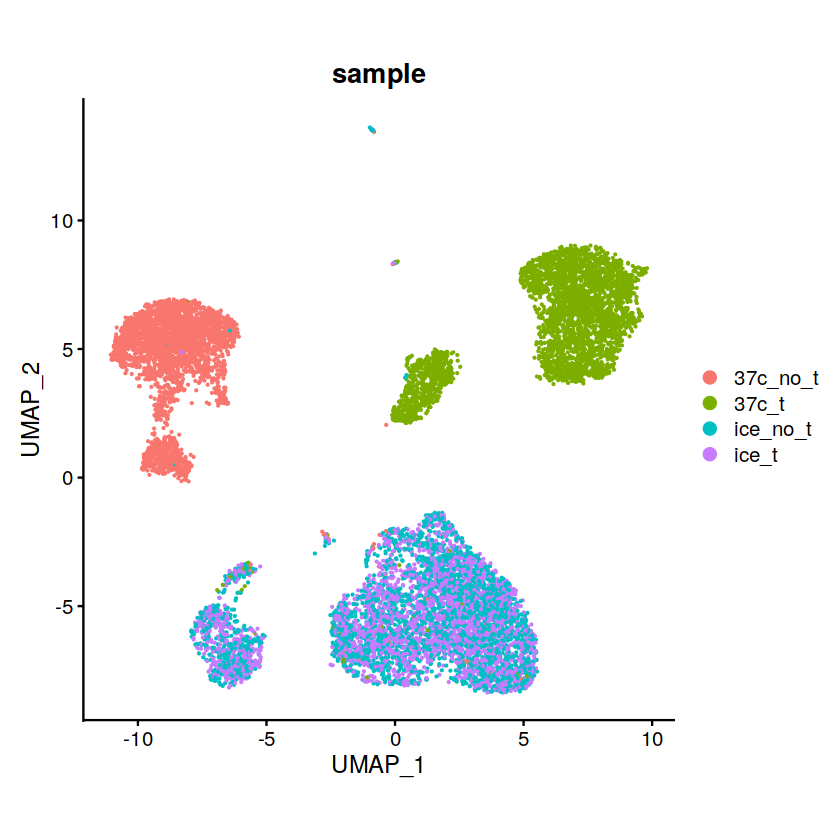

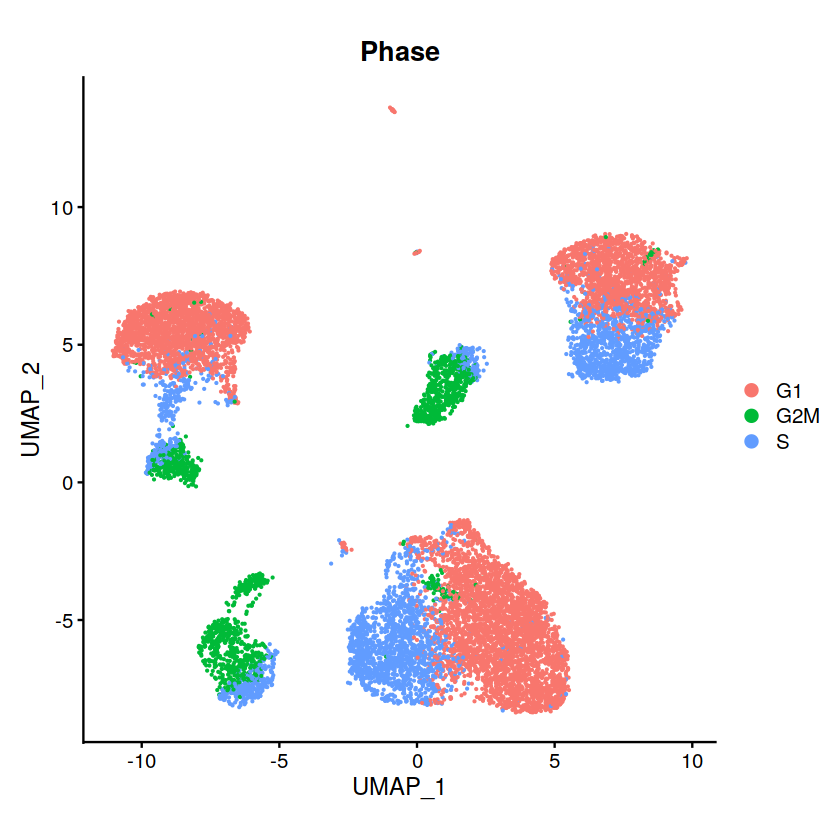

In [45]:
#| label: fig-dimplots
#| fig-cap: "UMAP coloured on metadata"
#| fig-subcap: 
#|   - "Coloured on condition/sample"
#|   - "Coloured on cell cycle phases"
#| layout-ncol: 2
DimPlot(sobj, group.by = "sample") + coord_fixed()
DimPlot(sobj, group.by = "Phase") + coord_fixed()

In [64]:
#| label: tbl-phase-sample
#| tbl-cap: "Cell cycle phase classification distribution per condition"
table(sobj[[]][,c("sample", "Phase")]) %>% as.data.frame.matrix

,G1,G2M,S
,<int>,<int>,<int>
37c_no_t,2164,334,375
37c_t,1799,608,1173
ice_no_t,1825,351,872
ice_t,1760,360,945


---

# Old DEG analysis

From former analysis we performed differential gene expression testing cell cycle phase-wise. The comparison was between conditions/samples. This yielded the following set of files:


In [44]:
system("ls ../data/processed/deg/", intern = T)

[1] "Archive.zip"                      "deg_G1_37c_no_t_vs_37c_t.tsv"    
 [3] "deg_G1_ice_no_t_vs_37c_no_t.tsv"  "deg_G1_ice_no_t_vs_ice_t.tsv"    
 [5] "deg_G1_ice_t_vs_37c_t.tsv"        "deg_G1_ice_vs_37c_no_t.tsv"      
 [7] "deg_G1_ice_vs_37c_t.tsv"          "deg_G2M_37c_no_t_vs_37c_t.tsv"   
 [9] "deg_G2M_ice_no_t_vs_37c_no_t.tsv" "deg_G2M_ice_no_t_vs_ice_t.tsv"   
[11] "deg_G2M_ice_t_vs_37c_t.tsv"       "deg_G2M_ice_vs_37c_no_t.tsv"     
[13] "deg_G2M_ice_vs_37c_t.tsv"         "deg_S_37c_no_t_vs_37c_t.tsv"     
[15] "deg_S_ice_no_t_vs_37c_no_t.tsv"   "deg_S_ice_no_t_vs_ice_t.tsv"     
[17] "deg_S_ice_t_vs_37c_t.tsv"         "deg_S_ice_vs_37c_no_t.tsv"       
[19] "deg_S_ice_vs_37c_t.tsv"

```{mermaid}
%%| label: fig-diagram
%%| fig-cap: "Schema for (old) DEG comparisons to follow."
flowchart TB
  subgraph ice with triptolide
  G1_ice[G1]
  G2M_ice[G2M]
  S_ice[S]
  end
  subgraph 37c with triptolide
  G1_37c[G1] --- G1_ice
  G2M_37c[G2M] --- G2M_ice
  S_37c[S] --- S_ice
  end
```

For each file, both up- and down-regulated genes are included. Here we have loaded the comparison between 37c with triptolide and ice with triptolide (see @fig-diagram). So first we have the top 6 ice-specific, for the G1 phase:

In [24]:
#| code-fold: false
degs[["G1"]] %>% head

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zfp36l2,0,1.958553,0.990,0.439,0
Mir142hg,0,1.894032,0.962,0.245,0
Txnip,0,1.855793,0.945,0.183,0
Sox4,0,1.635571,0.945,0.458,0
Dapp1,0,1.552930,0.966,0.568,0
Gcnt2,0,1.479956,0.959,0.586,0


And the top 6 37c-specific, for the G1 phase as well:

In [25]:
#| code-fold: false
degs[["G1"]] %>% tail

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sh2b2,0.000000e+00,-1.357543,0.093,0.691,0.000000e+00
A930015D03Rik,3.628043e-15,-1.372958,0.487,0.298,1.171314e-10
Asah2,7.332960e-212,-1.375551,0.322,0.723,2.367446e-207
Bcl2l14,3.884711e-151,-1.661921,0.061,0.419,1.254179e-146
Gm40841,0.000000e+00,-1.682257,0.040,0.759,0.000000e+00
4933406J09Rik,0.000000e+00,-2.247251,0.101,0.844,0.000000e+00


---

## DEGs visualized on UMAP

### G1

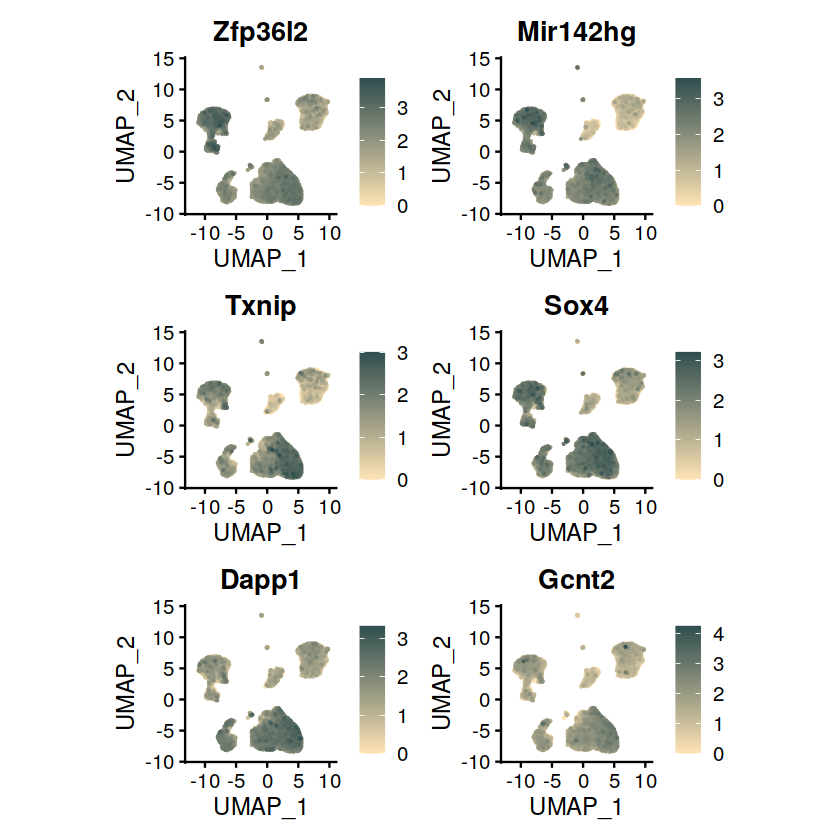

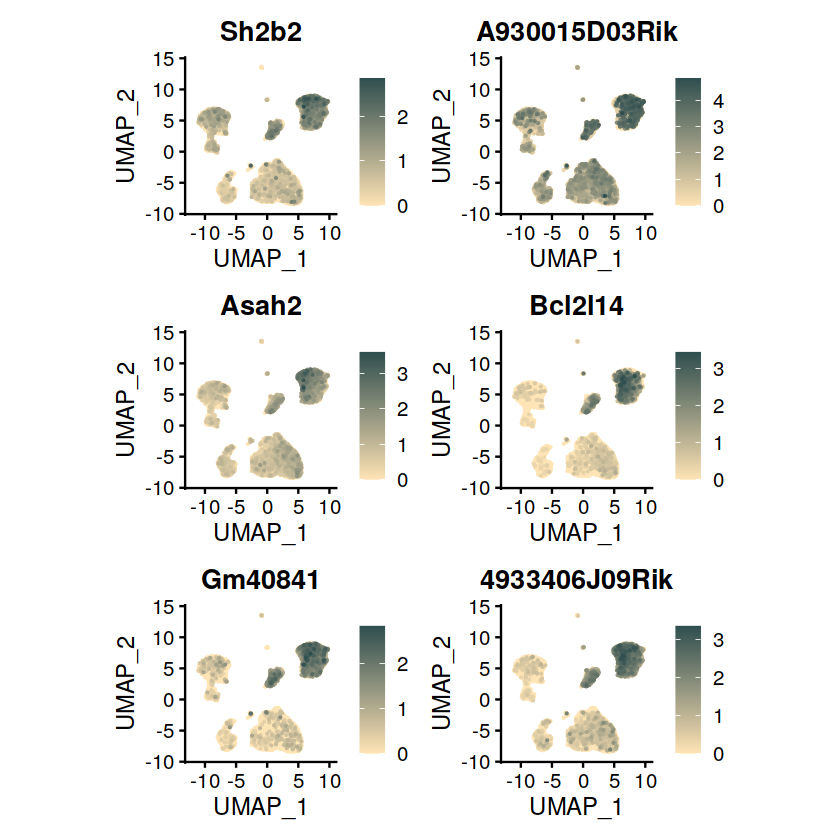

In [93]:
#| label: fig-deg-old-g1
#| fig-cap: "Top DEGs for phase **G1**."
#| fig-subcap: 
#|   - "Top 6 DEGs specific to **ice w/ t** condition"
#|   - "Top 6 DEGs specific to **37c w/ t** condition"
#| layout-ncol: 1
FeaturePlot(sobj, features = degs[["G1"]] %>% head %>% rownames, coord.fixed = T, order = T, cols = cols_features)
FeaturePlot(sobj, features = degs[["G1"]] %>% tail %>% rownames, coord.fixed = T, order = T, cols = cols_features)

### G2M

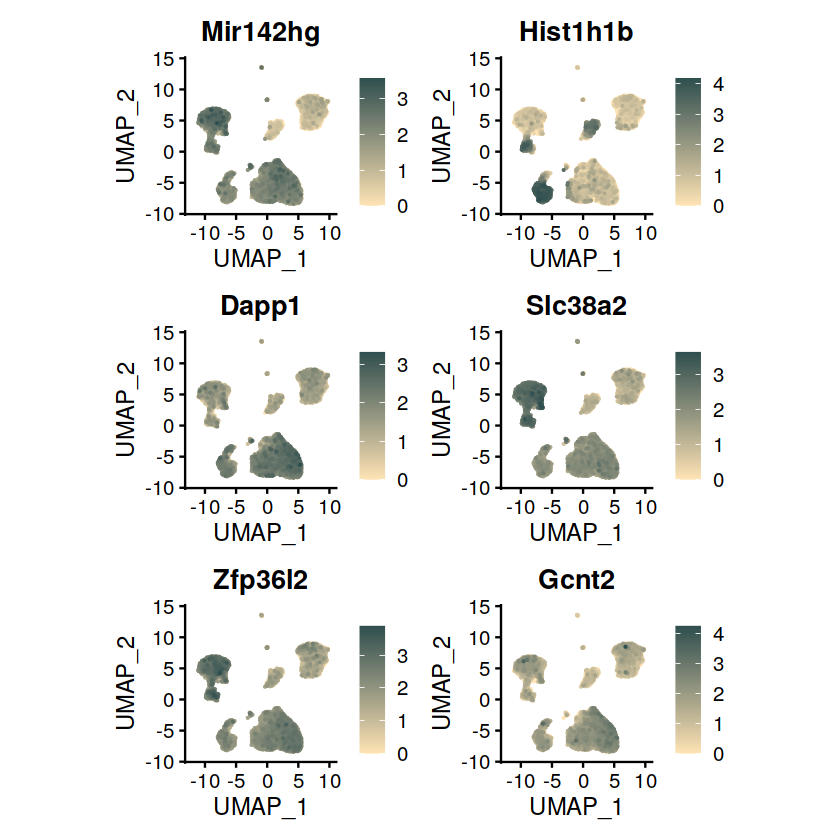

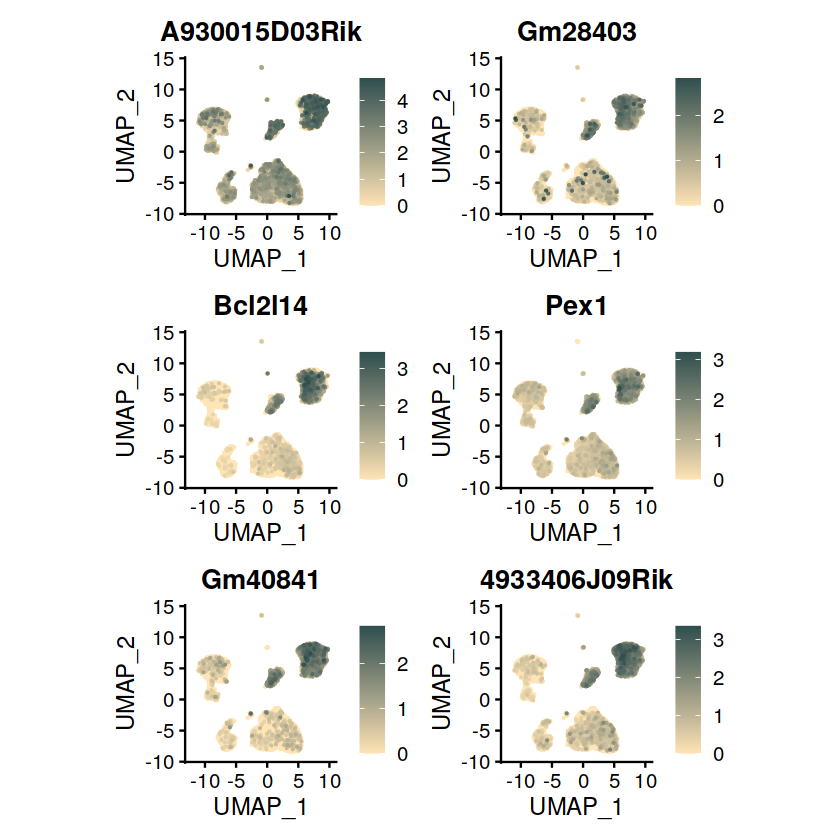

In [94]:
#| label: fig-deg-old-g2m
#| fig-cap: "Top DEGs for phase **G2M**."
#| fig-subcap: 
#|   - "Top 6 DEGs specific to **ice w/ t** condition"
#|   - "Top 6 DEGs specific to **37c w/ t** condition"
#| layout-ncol: 1
FeaturePlot(sobj, features = degs[["G2M"]] %>% head %>% rownames, coord.fixed = T, order = T, cols = cols_features)
FeaturePlot(sobj, features = degs[["G2M"]] %>% tail %>% rownames, coord.fixed = T, order = T, cols = cols_features)

### S

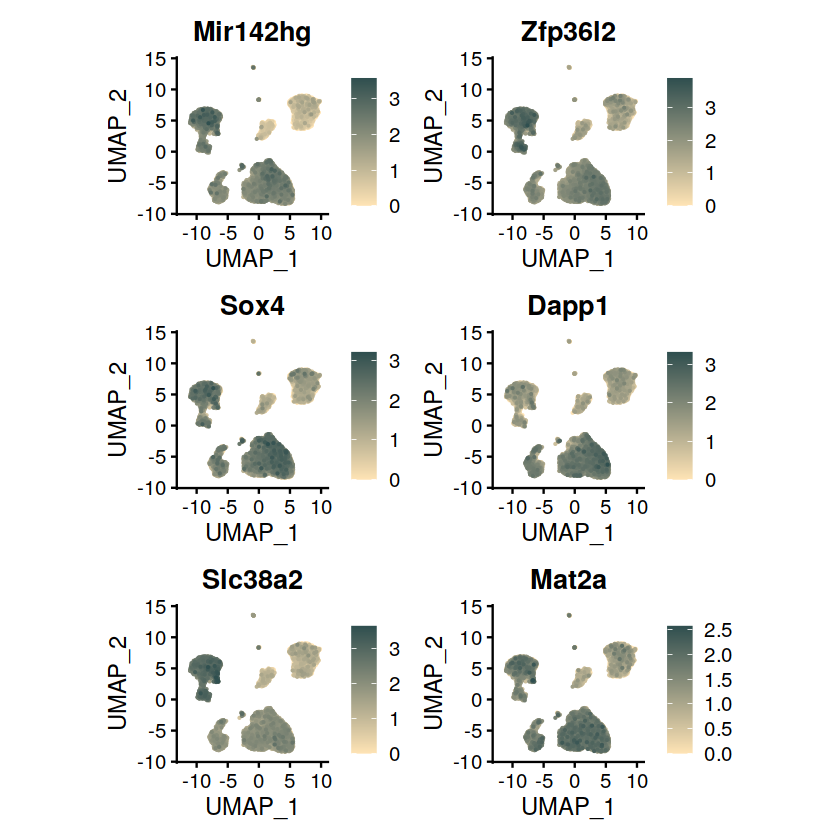

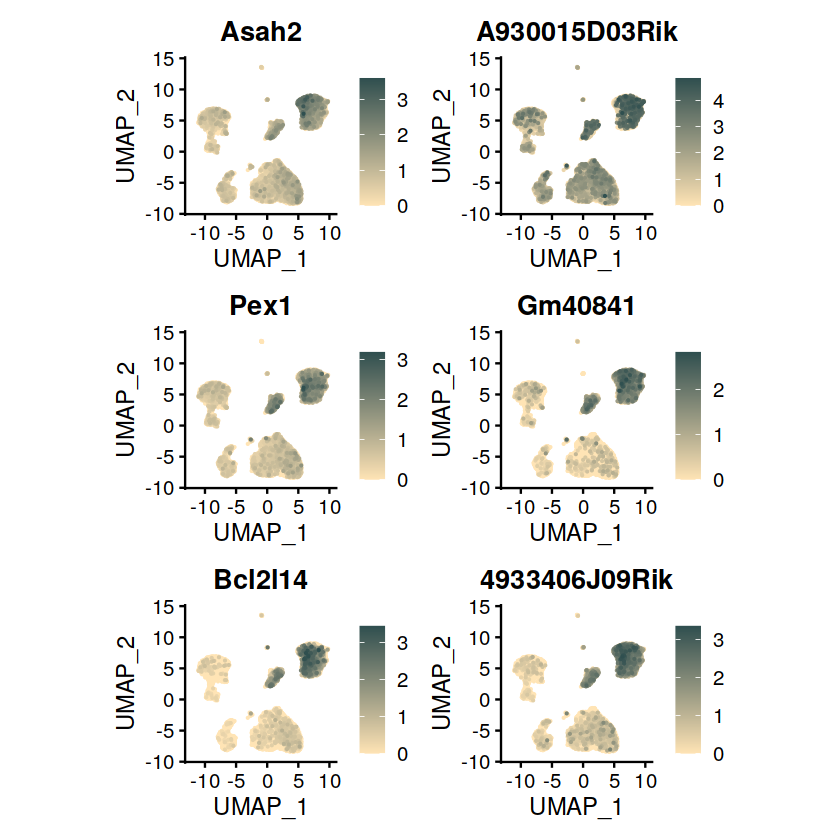

In [95]:
#| label: fig-deg-old-s
#| fig-cap: "Top DEGs for phase **S**."
#| fig-subcap: 
#|   - "Top 6 DEGs specific to **ice w/ t** condition"
#|   - "Top 6 DEGs specific to **37c w/ t** condition"
#| layout-ncol: 1
FeaturePlot(sobj, features = degs[["S"]] %>% head %>% rownames, coord.fixed = T, order = T, cols = cols_features)
FeaturePlot(sobj, features = degs[["S"]] %>% tail %>% rownames, coord.fixed = T, order = T, cols = cols_features)

---

# New DEG analysis

Specifically done _not_ cell cycle phase-wise. Will be done for:

- 37c with tript _VS_ ice with tript

```{mermaid}
%%| label: fig-diagram-new
%%| fig-cap: "Schema for new DEG comparison."
flowchart TB
  subgraph ice with triptolide
  ice[G1, G2M, S]
  end
  subgraph 37c with triptolide
  37c[G1, G2M, S] --- ice
  end
```

##  37c with tript _vs_ ice with tript

Sample names used in object:

In [66]:
sobj[[]][["sample"]] %>% unique

[1] "37c_no_t" "ice_t"    "37c_t"    "ice_no_t"

In [76]:
#| code-fold: false
Idents(sobj) <- "sample"
DefaultAssay(sobj) <- "RNA"
new_degs <- FindMarkers(sobj, ident.1 = "37c_t", ident.2 = "ice_t", assay = "RNA", features = VariableFeatures(sobj)) %>% arrange(desc(avg_log2FC))

### DEG table

In [77]:
#| label: tbl-new-degs
#| tbl-cap: "Differentially expressed genes between `37c_t` and `ice_t`. Positive fold change = up in `37c_t`, negative fold change = up in `ice_t`."
new_degs

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4933406J09Rik,0.000000e+00,2.0847480,0.862,0.115,0.000000e+00
Bcl2l14,0.000000e+00,1.6003084,0.465,0.052,0.000000e+00
Gm40841,0.000000e+00,1.5380264,0.771,0.039,0.000000e+00
A930015D03Rik,3.476910e-33,1.2839138,0.339,0.552,1.122520e-28
Sh2b2,0.000000e+00,1.2106941,0.709,0.127,0.000000e+00
Asah2,0.000000e+00,1.2047546,0.730,0.334,0.000000e+00
Arhgap15,0.000000e+00,1.1174486,0.996,0.989,0.000000e+00
Pex1,0.000000e+00,1.0954294,0.599,0.195,0.000000e+00
Gm28403,0.000000e+00,1.0177440,0.566,0.076,0.000000e+00


### DEG visualizations

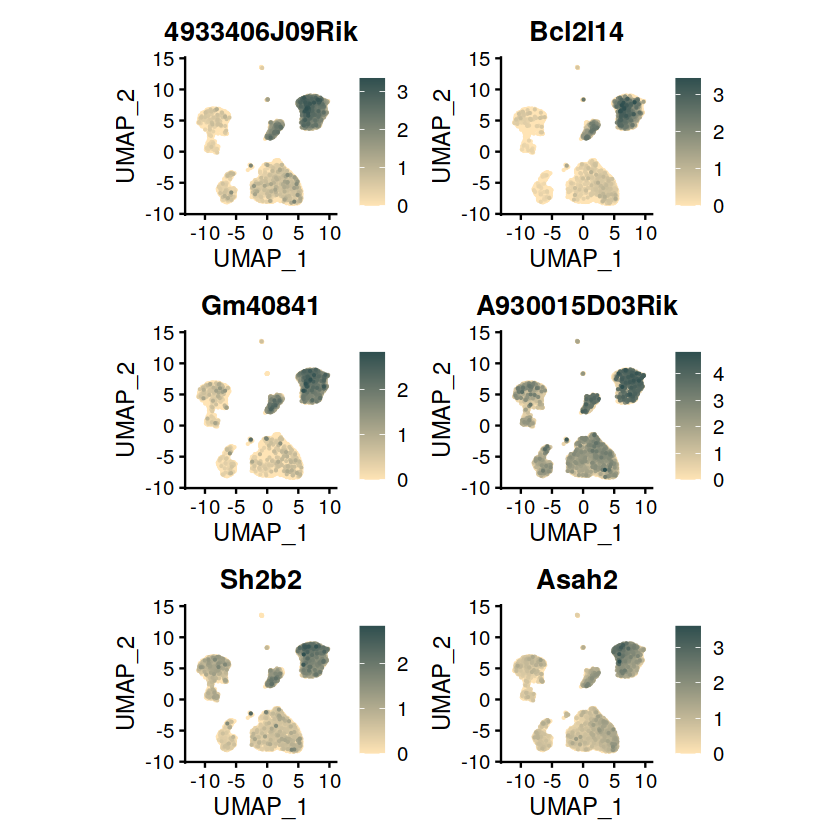

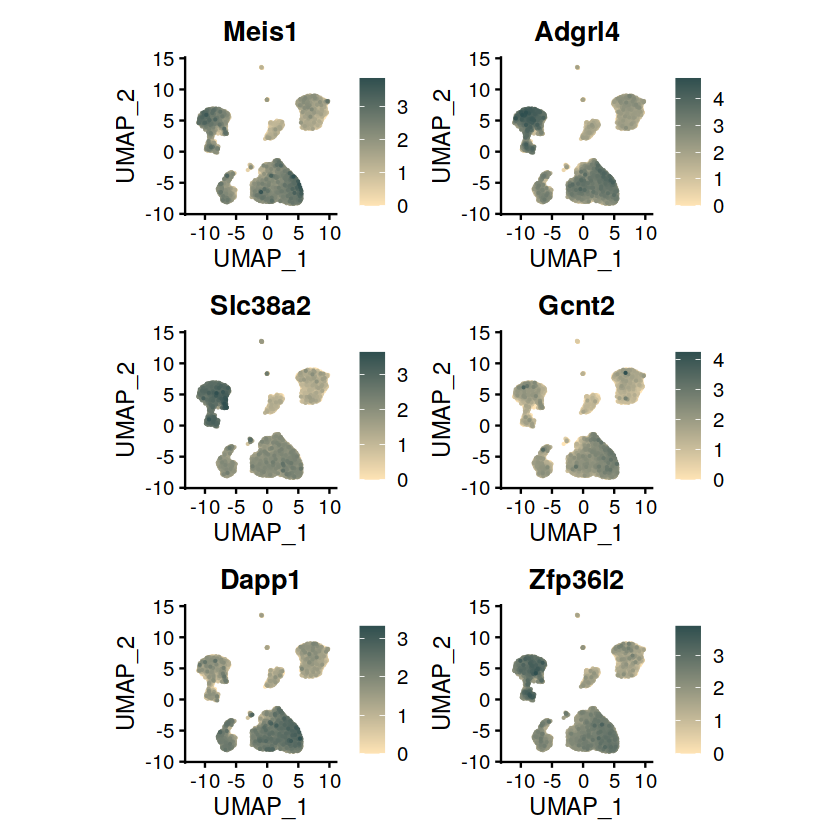

In [96]:
#| label: fig-deg-new
#| fig-cap: "Top DEGs between 37c with triptolide and ice with triptolide."
#| fig-subcap: 
#|   - "Top 6 DEGs specific to **`37c_t`** condition"
#|   - "Top 6 DEGs specific to **`ice_t`** condition"
#| layout-ncol: 1
FeaturePlot(sobj, features = new_degs %>% head %>% rownames, coord.fixed = T, order = T, cols = cols_features)
FeaturePlot(sobj, features = new_degs %>% tail %>% rownames, coord.fixed = T, order = T, cols = cols_features)